# C S 329E HW 11

# Association Analysis - Frequent Itemsets and Rule Generation

## Marissa Green

Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - Date: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - Time: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - Transaction: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - Item: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [1]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Q1 - Data Analysis
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset 
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

In [2]:
# read in dataset as a df
df = pd.read_csv('BreadBasket.csv')

# remove all items with the name NONE
df = df[df["Item"] != "NONE"]

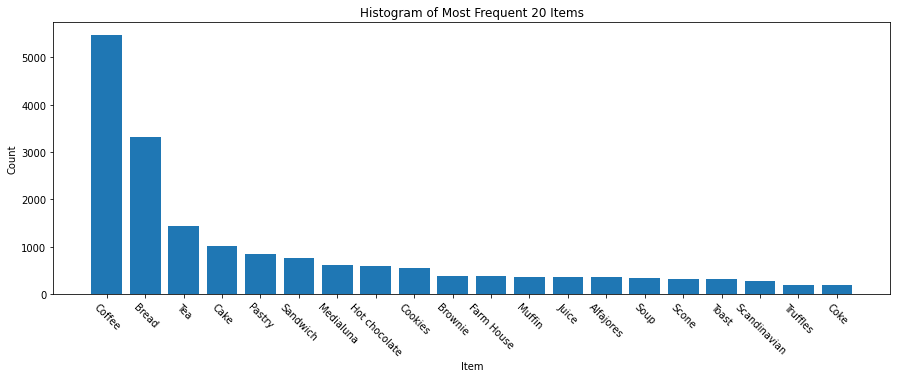

In [3]:
# find most frequent 20 items
unique_vals = df["Item"].value_counts()
top_20_vals = unique_vals[0:20]

# Plot the most frequent 20 items in a a histogram
plt.figure(figsize=(15, 5))
plt.bar(top_20_vals.index, list(top_20_vals))
plt.title("Histogram of Most Frequent 20 Items")
plt.xlabel("Item")
plt.ylabel("Count")
plt.xticks(rotation=-45)
plt.show()

In [4]:
# Calculate how many unique items are in the dataset 
print("There are "+str(len(unique_vals))+" unique items in the dataset.")

There are 94 unique items in the dataset.


In [5]:
# Calculate how many transactions there are in the dataset
num_transactions = len(df["Transaction"].value_counts())
print("There are "+str(num_transactions)+ " transactions in the dataset.")

There are 9465 transactions in the dataset.


## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [6]:
# create transaction array
list_transactions = df.groupby("Transaction")["Item"].apply(list)

In [7]:
# Use the mlxtend TransactionEncoder library to encode the transaction array in a one hot encoding
te = TransactionEncoder()
te_ary = te.fit(list_transactions).transform(list_transactions)
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [8]:
# check it was done properly by looking at the first 4 transactions using the inverse_transform
print(te.inverse_transform(te_ary[:4]))

# my df's first four:
df[df["Transaction"] < 5]

[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
5,2016-10-30,10:07:57,3,Cookies
6,2016-10-30,10:08:41,4,Muffin


In [9]:
# converting the transactions back to a dataframe using the documentation as a reference.
df = pd.DataFrame(te_ary, columns=te.columns_)

## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [10]:
minsup = 20
min_support = minsup/num_transactions
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

In [11]:
frequent_itemsets["itemsets"][-15:]

229                (Coffee, Tea, Cookies)
230    (Medialuna, Coffee, Hot chocolate)
231       (Pastry, Coffee, Hot chocolate)
232     (Sandwich, Coffee, Hot chocolate)
233             (Sandwich, Juice, Coffee)
234           (Medialuna, Coffee, Pastry)
235              (Medialuna, Coffee, Tea)
236                 (Coffee, Muffin, Tea)
237                 (Coffee, Tea, Pastry)
238              (Sandwich, Coffee, Soup)
239               (Sandwich, Coffee, Tea)
240          (Truffles, Sandwich, Coffee)
241                  (Coffee, Scone, Tea)
242                   (Coffee, Soup, Tea)
243                  (Toast, Coffee, Tea)
Name: itemsets, dtype: object

## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [12]:
assoc_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [21]:
def trim_rules(assoc_rules, conf_threshold, lift_threshold):
    return assoc_rules[(assoc_rules["confidence"] >= conf_threshold) & (assoc_rules["lift"] >= lift_threshold)]
    #return sliced[sliced["lift"] >= lift_threshold]

trim_rules(assoc_rules, 0.6, 1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
11,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
14,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648
18,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404
21,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
27,"(Cake, Hot chocolate)",(Coffee),0.011410,0.478394,0.006867,0.601852,1.258067,0.001409,1.310080
29,"(Medialuna, Cake)",(Coffee),0.003698,0.478394,0.002536,0.685714,1.433367,0.000767,1.659655
31,"(Sandwich, Cake)",(Coffee),0.006867,0.478394,0.004649,0.676923,1.414990,0.001363,1.614495


➡️ _All of the rules have a consequent of coffee. The association rules are all cross-support patterns because coffee is by far the most freuqently item bought according to my histogram. This is not helpful, as the rules aren't providing any specific insight into transactions. Regardless of what the customer bought, the strong rules predict they want coffee too._ ⬅️

### Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [14]:
association_rules(frequent_itemsets, metric="lift", min_threshold=3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Sandwich),(Coke),0.071844,0.019440,0.005177,0.072059,3.706722,0.003780,1.056705
1,(Coke),(Sandwich),0.019440,0.071844,0.005177,0.266304,3.706722,0.003780,1.265043
2,(Fudge),(Jam),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
3,(Jam),(Fudge),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
4,(Juice),(Jammie Dodgers),0.038563,0.013207,0.002113,0.054795,4.149041,0.001604,1.043999
5,(Jammie Dodgers),(Juice),0.013207,0.038563,0.002113,0.160000,4.149041,0.001604,1.144568
6,(Juice),(Spanish Brunch),0.038563,0.018172,0.002747,0.071233,3.919879,0.002046,1.057130
7,(Spanish Brunch),(Juice),0.018172,0.038563,0.002747,0.151163,3.919879,0.002046,1.132652
8,(Sandwich),(Mineral water),0.071844,0.014157,0.003275,0.045588,3.220094,0.002258,1.032932
9,(Mineral water),(Sandwich),0.014157,0.071844,0.003275,0.231343,3.220094,0.002258,1.207504


In [15]:
association_rules(frequent_itemsets, metric="leverage", min_threshold=0.004)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
1,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
2,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910
3,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125
4,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
5,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
6,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
7,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
8,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
9,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682


In [16]:
association_rules(frequent_itemsets, metric="conviction", min_threshold=1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
1,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
2,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
3,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
4,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
5,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648
6,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
7,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
9,(Vegan mincepie),(Coffee),0.005494,0.478394,0.003170,0.576923,1.205958,0.000541,1.232887


## Q6 - Find the Maximal Itemsets
Using the frequent itemsets and support counts in Q3, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found. (MLxtend does not provide a function to do this - you will need to write it yourself.)

In [17]:
# find maximal itemsets
maximal = []
for itemset in frequent_itemsets["itemsets"]:
    itemset = list(itemset)
    
    # SUBSET CHECK
    # check if itemset is a subset of anything in maximal frequent itemsets 
    for i in maximal:
        if set(itemset) < (set(i)):
            break # end, not maximal

    # at this point, not a subset of anything in maximal frequent itemset, so add itemset 
    maximal.append(itemset)
    
    # SUPERSET CHECK
    for idx, i in enumerate(maximal):
        if set(i) < (set(itemset)):
            del maximal[idx]

In [18]:
# display all maximal frequent itemsets along with their support fraction
for maximal_itemset in maximal:  
    for idx, itemset in enumerate(frequent_itemsets["itemsets"]):
        if maximal_itemset == list(itemset):
            print("Maximal frequent itemset", maximal_itemset, "with support", frequent_itemsets["support"][idx])

Maximal frequent itemset ['Afternoon with the baker'] with support 0.004543053354463814
Maximal frequent itemset ['Eggs'] with support 0.0029582673005810883
Maximal frequent itemset ['Focaccia'] with support 0.005705229793977813
Maximal frequent itemset ['Granola'] with support 0.0029582673005810883
Maximal frequent itemset ['Tshirt'] with support 0.0022187004754358162
Maximal frequent itemset ['Alfajores', 'Brownie'] with support 0.0028526148969889066
Maximal frequent itemset ['Alfajores', 'Cookies'] with support 0.0024300052826201797
Maximal frequent itemset ['Alfajores', 'Hot chocolate'] with support 0.0035921817221341787
Maximal frequent itemset ['Juice', 'Alfajores'] with support 0.00306391970417327
Maximal frequent itemset ['Medialuna', 'Alfajores'] with support 0.003169572107765452
Maximal frequent itemset ['Alfajores', 'Pastry'] with support 0.0032752245113576335
Maximal frequent itemset ['Sandwich', 'Alfajores'] with support 0.002641310089804543
Maximal frequent itemset ['Art 

In [19]:
# print how many maximal frequent itemsets there are
print("There are", len(maximal), "maximal frequent itemsets.")

There are 139 maximal frequent itemsets.


## Q7 - Create Actionable Buisness Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

➡️ _According to the histogram of top 20 frequently bought items, coffee is the most frequently bought and sought after item. Therefore, I would advertise a special of free coffee with the purchase of 2 or more other bakery items. Most people already want coffee, so they would see a free coffee as a good deal. This is a smart business move because people would likely buy more of the other bakery items for the free coffee._ ⬅️